### 0. 环境

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import keras
from glob import glob
print('tf version', tf.__version__)
print('keras version', keras.__version__)

/Users/orange/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tf version 1.4.0
keras version 2.1.4


Using TensorFlow backend.


### 1. 查看数据

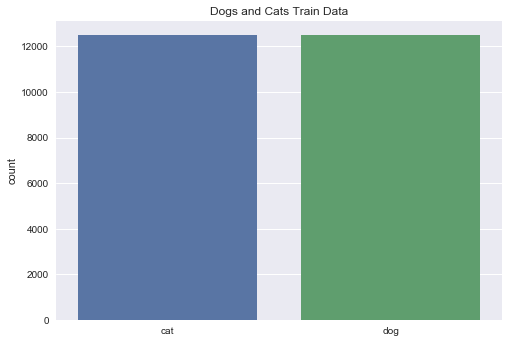

In [2]:
import seaborn as sns
import os 
data_dir = './data/train/'
all_files = os.listdir(data_dir)
labels = []
for f in all_files:
    labels.append(f[:3])
sns.countplot(labels)
sns.plt.title('Dogs and Cats Train Data')
sns.plt.show()

In [3]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(16, 8))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, interpolation='nearest')
        a.set_title(title)
        a.axis('off')
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

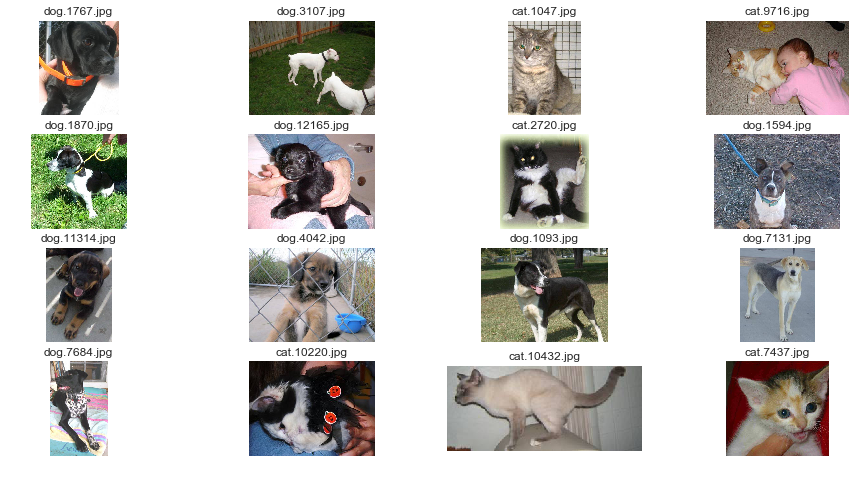

In [4]:
NUM_SHOWS = 16
data_dir = './data/train/'
all_files = os.listdir(data_dir)
rand_indices = np.random.randint(0, len(all_files), NUM_SHOWS)
a = np.array(all_files, dtype=np.str)[rand_indices]
titles = [all_files[i][:] for i in rand_indices]
show_images([np.array(PIL.Image.open(os.path.join(data_dir, i)).convert('RGB')) for i in a], NUM_SHOWS/4, titles)

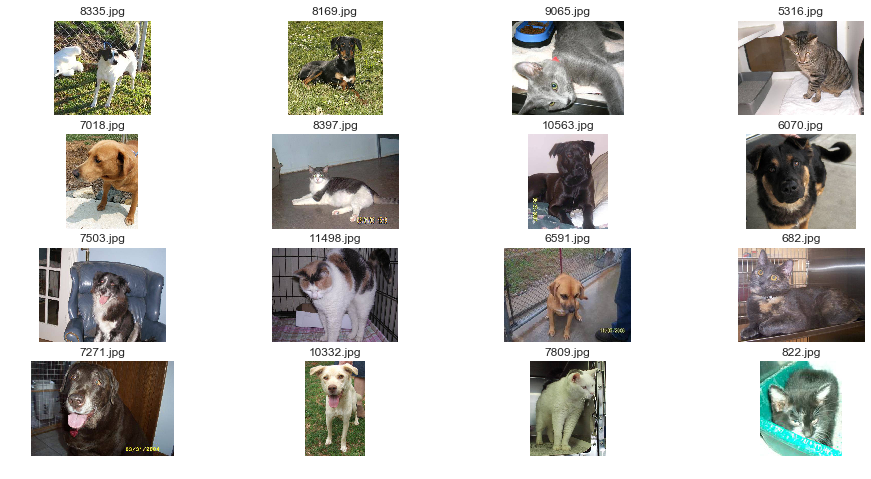

In [5]:
NUM_SHOWS = 16
test_dir = './data/test/test/'
all_files = os.listdir(test_dir)
rand_indices = np.random.randint(0, len(all_files), NUM_SHOWS)
a = np.array(all_files, dtype=np.str)[rand_indices]
titles = [all_files[i][:] for i in rand_indices]
show_images([np.array(PIL.Image.open(os.path.join(test_dir, i)).convert('RGB')) for i in a], NUM_SHOWS/4, titles)

### 2. 数据预处理

In [6]:
import os
import shutil

data_dir = './data/train/'

files = os.listdir(data_dir)
train_cats = filter(lambda x:x.find('cat') != -1, files)
train_dogs = filter(lambda x:x.find('dog') != -1, files)

train_dir = 'train_data'
test_dir = './data/test/'

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
if not os.path.exists(os.path.join(train_dir, 'cat')):
    os.mkdir(os.path.join(train_dir, 'cat'))
    for f in train_cats:
        # don't Know why ImageDataGenerator#flor_from_directoty didn't work if use os.symlink here ???!!!
        shutil.copy(os.path.join(data_dir, f), os.path.join(train_dir, 'cat', f))
    
if not os.path.exists(os.path.join(train_dir, 'dog')):
    os.mkdir(os.path.join(train_dir, 'dog'))
    for f in train_dogs:
        shutil.copy(os.path.join(data_dir, f), os.path.join(train_dir, 'dog', f))


### 2. 下载模型

#### InceptionV3

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as pre_input_v3

base_model_v3 = InceptionV3(weights='imagenet', include_top=False)

#### InceptionResnetV2

In [8]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as pre_input_resnet_v2

model_inception_resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False)

### 3.开始

##### 不要最后一层，创建自己的分类器，只训练最后一层

#### 3.1 载入模型

In [9]:
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D

In [10]:
model_v3_gap = Model(base_model_v3.input, GlobalAveragePooling2D()(base_model_v3.output))
print(model_v3_gap.output.shape)


(?, 2048)


In [11]:
model_irv2_gap = Model(model_inception_resnet_v2.input, GlobalAveragePooling2D()(model_inception_resnet_v2.output))
print(model_irv2_gap.output.shape)

(?, 1536)


#### 3.2 提取特征

In [12]:
from keras.preprocessing.image import *
import numpy as np

IMAGE_WIDTH, IMAGE_HEIGHT = 299, 299
n_classes = 2
batch_size = 16
epochs = 10

train_dir = 'train_data/'
test_dir = 'data/test/'
def generate_bottleneck(features_file_name, model_gap, preprocess_function):
    print('%s begin'%features_file_name)
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
    train_generator = train_gen.flow_from_directory(train_dir,
                                                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                  shuffle=False,
                                                  batch_size=1,
                                                  class_mode='categorical')
    
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
    test_generator = test_gen.flow_from_directory(test_dir,
                                                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                  shuffle=False,
                                                  batch_size=1,
                                                  class_mode=None)  

    
    if os.path.exists('%s_train.npz'%features_file_name):
        print('train features already calculcated before')
        # TODO
    else:
        features = model_gap.predict_generator(train_generator, len(train_generator))
        features = np.squeeze(features)
        np.savez('%s_train.npz'%features_file_name, features=features, labels=train_generator.classes)
        print('train features saved')
        
    if os.path.exists('%s_test.npz'%features_file_name):
        print('test features already calculated before')
        # TODO
    else:
        print(len(test_generator))
        test_features = model_gap.predict_generator(test_generator, len(test_generator))
        test_features = np.squeeze(test_features)
        np.savez('%s_test.npz'%features_file_name, features=test_features)
        print('test features saved')
    print('%s done'%features_file_name)

In [13]:
import time
start = time.time()

generate_bottleneck('inception_v3', model_v3_gap, pre_input_v3)
generate_bottleneck('inception_resnet_v2', model_irv2_gap, pre_input_resnet_v2)

print(time.time() - start)

inception_v3 begin
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
train features already calculcated before
test features already calculated before
inception_v3 done
inception_resnet_v2 begin
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
train features already calculcated before
test features already calculated before
inception_resnet_v2 done
4.358182907104492


#### 3.3 训练分类器

In [14]:
from keras.models import *
from keras.layers import *

print(*model_v3_gap.output.get_shape()[1:].as_list())
print(*model_irv2_gap.output.get_shape()[1:].as_list())

2048
1536


##### 3.3.1 InceptionV3

In [30]:
input_tensor = Input((*model_v3_gap.output.get_shape()[1:].as_list(),), name='InceptionV3_Output') # 2048
x = input_tensor
x = Dropout(0.5, name='Dropout')(input_tensor)
dense_tensor = Dense(2, activation='softmax', name='classifier')(x)
model_iv3 = Model(inputs=input_tensor, outputs=dense_tensor)
model_iv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_iv3.summary()
#SVG(model_to_dot(model_iv3, show_shapes=True).create(format='svg', prog='dot'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InceptionV3_Output (InputLay (None, 2048)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


##### 3.3.2 InceptionResNetV2

In [31]:
input_tensor = Input((*model_irv2_gap.output.get_shape()[1:].as_list(),)) # 1536
x = Dropout(0.5)(input_tensor)
dense_tensor = Dense(2, activation='softmax')(x)
model_irv2 = Model(inputs=input_tensor, outputs=dense_tensor)
model_irv2.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_irv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3074      
Total params: 3,074
Trainable params: 3,074
Non-trainable params: 0
_________________________________________________________________


##### 3.4 开始训练

##### 3.4.1 加载之前提取的特征

In [24]:
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
def load_bottlenecks_train(filename):
    features_train = np.load(filename)
    X_train = features_train['features']
    y_train = features_train['labels']

    np.random.seed(2018)
    X_train, y_train = shuffle(X_train, y_train, random_state=2018)

    y_train_categroical = to_categorical(y_train, num_classes=2) # https://keras.io/losses/
    return X_train, y_train_categroical

In [18]:
# also see https://keras.io/callbacks
def show_fit_history(history, model_name='', vline=0):
    # acc
    plt.figure()
    plt.title(model_name)
    plt.plot(history.history['acc'], label='train_acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend(loc="lower right")
    plt.grid(True)
    if vline != 0:
        plt.vlines(vline, plt.ylim()[0], plt.ylim()[1], colors = "r", linestyles = "dashed")
    plt.show()
    
    # loss
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc="upper right")
    plt.grid(True)
    if vline != 0:
        plt.vlines(vline, plt.ylim()[0], plt.ylim()[1], colors = "r", linestyles = "dashed")
    plt.show()


In [19]:
early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=-0.002, patience=0, verbose=1, mode='auto')

In [20]:
X_train_iv3, y_train_categroical_iv3 = load_bottlenecks_train('inception_v3_train.npz')

In [32]:
history = model_iv3.fit(X_train_iv3, 
                        y_train_categroical_iv3, 
                        batch_size=128, 
                        epochs=7, 
                        validation_split=0.2,
                        callbacks=[early_stop_cb])

Train on 20000 samples, validate on 5000 samples
Epoch 1/7
20000/20000 [==============================] - 3s 158us/step - loss: 0.1038 - acc: 0.9628 - val_loss: 0.0319 - val_acc: 0.9930
Epoch 2/7
20000/20000 [==============================] - 1s 48us/step - loss: 0.0334 - acc: 0.9909 - val_loss: 0.0268 - val_acc: 0.9906
Epoch 3/7
20000/20000 [==============================] - 1s 42us/step - loss: 0.0278 - acc: 0.9919 - val_loss: 0.0212 - val_acc: 0.9938
Epoch 4/7
20000/20000 [==============================] - 1s 43us/step - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0223 - val_acc: 0.9922
Epoch 5/7
20000/20000 [==============================] - 1s 42us/step - loss: 0.0240 - acc: 0.9923 - val_loss: 0.0240 - val_acc: 0.9918
Epoch 6/7
20000/20000 [==============================] - 1s 42us/step - loss: 0.0242 - acc: 0.9925 - val_loss: 0.0198 - val_acc: 0.9932
Epoch 7/7
20000/20000 [==============================] - 1s 43us/step - loss: 0.0234 - acc: 0.9926 - val_loss: 0.0190 - val_acc: 0.994

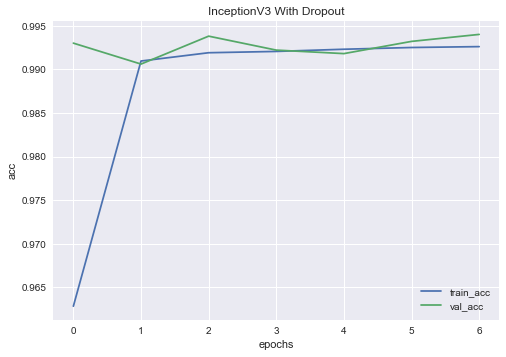

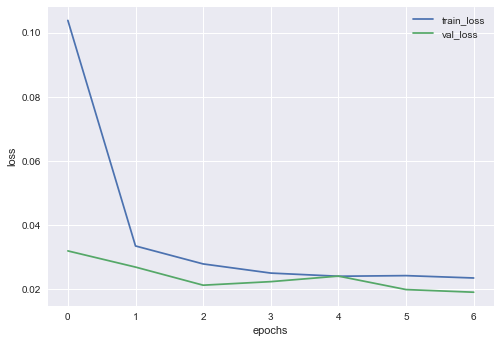

In [33]:
show_fit_history(history, 'InceptionV3 With Dropout')

In [28]:
X_train_irv2, y_train_categroical_irv2 = load_bottlenecks_train('inception_resnet_v2_train.npz')

In [34]:
history_irv2 = model_irv2.fit(X_train_irv2, 
                              y_train_categroical_irv2, 
                              batch_size=128, 
                              epochs=10, 
                              validation_split=0.2,
                              callbacks=[early_stop_cb])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 142us/step - loss: 0.0895 - acc: 0.9714 - val_loss: 0.0311 - val_acc: 0.9938
Epoch 2/10
20000/20000 [==============================] - 1s 47us/step - loss: 0.0303 - acc: 0.9931 - val_loss: 0.0244 - val_acc: 0.9948
Epoch 3/10
20000/20000 [==============================] - 1s 41us/step - loss: 0.0244 - acc: 0.9938 - val_loss: 0.0235 - val_acc: 0.9940
Epoch 4/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.0241 - acc: 0.9939 - val_loss: 0.0236 - val_acc: 0.9940
Epoch 5/10
20000/20000 [==============================] - 1s 41us/step - loss: 0.0205 - acc: 0.9946 - val_loss: 0.0208 - val_acc: 0.9952
Epoch 6/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.0217 - acc: 0.9941 - val_loss: 0.0204 - val_acc: 0.9952
Epoch 7/10
20000/20000 [==============================] - 1s 41us/step - loss: 0.0197 - acc: 0.9947 - val_loss: 0.0201 - val_acc

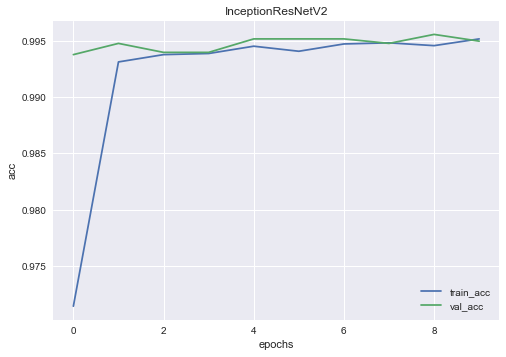

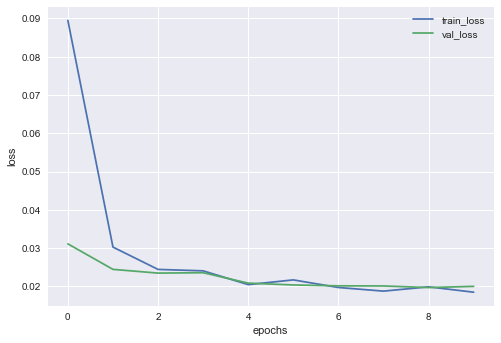

In [35]:
show_fit_history(history_irv2, "InceptionResNetV2")

##### 3.4.2 生成预测结果

In [36]:
import pandas as pd
def generate_result(model, X_test, img_size, result_name):
    y_pred = model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    
    df = pd.read_csv('sample_submission.csv')
    
    gen = ImageDataGenerator(preprocessing_function=pre_input_v3)
    test_generator_result = gen.flow_from_directory('data/test', img_size, 
                                               shuffle=False, batch_size=1, class_mode=None)
    for i, f in enumerate(test_generator_result.filenames):
        index = int(f[f.rfind('/')+1:f.rfind('.')])
        df.set_value(index-1, 'label', y_pred[i])#第2列对应image_id = 1

    final_file_name = 'pred_%s.csv'%result_name
    df.to_csv(final_file_name, index=None)
    print('y_pred has been save into', final_file_name)
    return df

In [37]:
features_test_iv3 = np.load('inception_v3_test.npz')
X_test_iv3 = features_test_iv3['features']
df = generate_result(model_iv3, X_test_iv3, (IMAGE_WIDTH, IMAGE_HEIGHT), "iv3")
df.head(10)

12500/12500 [==============================] - 2s 121us/step
Found 12500 images belonging to 1 classes.
y_pred has been save into pred_iv3.csv


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

In [38]:
features_test_irv2 = np.load('inception_resnet_v2_test.npz')
X_test_irv2 = features_test_irv2['features']
df = generate_result(model_irv2, X_test_irv2, (IMAGE_WIDTH, IMAGE_HEIGHT), "irv2")
df.head(10)

12500/12500 [==============================] - 2s 138us/step
Found 12500 images belonging to 1 classes.
y_pred has been save into pred_irv2.csv


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

这里提交了预测结果，InceptionV3最终Public Score为0.04048，而InceptionResNetV2为0.04778

##### 3.4.3 融合模型

In [39]:
shape = model_v3_gap.output.shape[1].value + model_irv2_gap.output.shape[1].value
print(shape)
input_tensor_iv3 = Input(model_v3_gap.output.get_shape()[1:].as_list())
input_tensor_irv2 = Input(model_irv2_gap.output.get_shape()[1:].as_list())
x = Concatenate()([input_tensor_iv3, input_tensor_irv2])
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model_ensemble = Model(inputs=[input_tensor_iv3, input_tensor_irv2], outputs=x)
model_ensemble.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ensemble.summary()

3584
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 3584)         0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 3584)         0           concatenate_3[0][0]              
_____

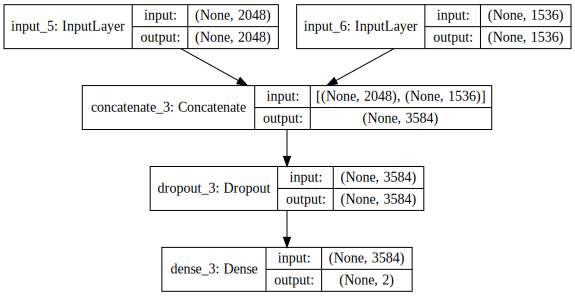

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_ensemble, show_shapes=True).create(format='svg', prog='dot'))

In [42]:
history_ensemble = model_ensemble.fit([X_train_iv3, X_train_irv2], 
                                      y_train_categroical_iv3, 
                                      batch_size=128, 
                                      epochs=4, 
                                      validation_split=0.2,
                                      callbacks=[early_stop_cb])

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 4s 175us/step - loss: 0.0619 - acc: 0.9783 - val_loss: 0.0199 - val_acc: 0.9956
Epoch 2/4
20000/20000 [==============================] - 1s 59us/step - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0169 - val_acc: 0.9956
Epoch 3/4
20000/20000 [==============================] - 1s 55us/step - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0172 - val_acc: 0.9956
Epoch 4/4
20000/20000 [==============================] - 1s 52us/step - loss: 0.0169 - acc: 0.9950 - val_loss: 0.0172 - val_acc: 0.9954


In [ ]:
'''
model_ensemble.optimizer = keras.optimizers.sgd(lr=0.0001)
history_ensemble_2 = model_ensemble.fit([X_train_iv3, X_train_irv2], 
                                        y_train_categroical, 
                                        batch_size=64, 
                                        epochs=8, 
                                        validation_split=0.2, 
                                        callbacks=[early_stop_cb])
for (k, v) in history_ensemble_2.history.items():
    history_ensemble.history[k].extend(v)
'''

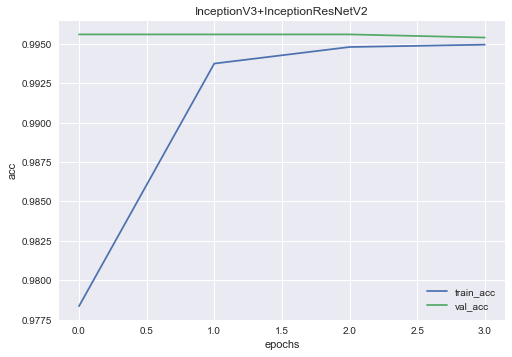

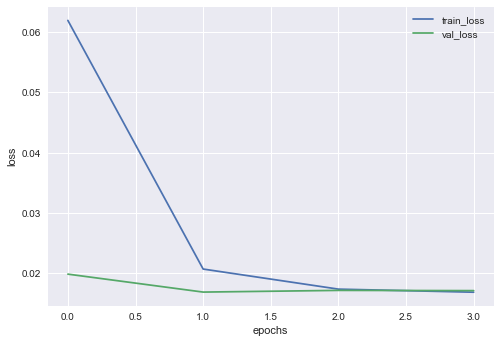

In [43]:
#show_fit_history(history_ensemble, 'ensemble', len(history_ensemble.epoch))
show_fit_history(history_ensemble, 'InceptionV3+InceptionResNetV2')

In [44]:
df = generate_result(model_ensemble, [X_test_iv3, X_test_irv2], (IMAGE_WIDTH, IMAGE_HEIGHT), "ensemble")
df.head(10)

12500/12500 [==============================] - 2s 140us/step
Found 12500 images belonging to 1 classes.
y_pred has been save into pred_ensemble.csv


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

这里把结果也提交到Kaggle，最终Public Score为0.04524，得分在InceptionV3和InceptionResNetV2之间

至此从目前的三个模型来看，表现最好的是InceptionV3，下面将以这个模型为基础，看看模型在拿到一张图的时候，它在“看”什么

#### 3.5 CAM

In [45]:
iv3 = InceptionV3(include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), weights='imagenet')
iv3 = Model(inputs=iv3.input, outputs=iv3.layers[-1].output, name='InceptionV3')

inputs_begin = Input((IMAGE_WIDTH, IMAGE_HEIGHT, 3), name='Image_Input')
x = inputs_begin
x = Lambda(pre_input_v3, name='preprocess')(x)
x = iv3(x)
cam = Conv2D(2, 1, use_bias=False, name='cam')(x) # (WIDTH, HEIGHT, NUM_CLASSES)
model_cam = Model(inputs=inputs_begin, outputs=cam)

x = GlobalAveragePooling2D(name='gap')(x)
x = model_iv3(x)
model_clf = Model(inputs=inputs_begin, outputs=x, )# no Dropout when predict

'''
x = inputs_begin
x = Lambda(pre_input_v3, name='preprocess')(x)
iv3x = iv3(x)
iv3x = GlobalAveragePooling2D(name='gap')(iv3x)
ivrv2x = Model(model_inception_resnet_v2.input, model_inception_resnet_v2.layers[-1].output, name="InceptionResNetV2")
ivrv2x = ivrv2x(x)
ivrv2x = GlobalAveragePooling2D(name='gap')(ivrv2x)

x = Concatenate()([iv3x, ivrv2x])
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model_clf_ensemble = Model(inputs=inputs_begin, outputs=x)
'''

'\nx = inputs_begin\nx = Lambda(pre_input_v3, name=\'preprocess\')(x)\niv3x = iv3(x)\niv3x = GlobalAveragePooling2D(name=\'gap\')(iv3x)\nivrv2x = Model(model_inception_resnet_v2.input, model_inception_resnet_v2.layers[-1].output, name="InceptionResNetV2")\nivrv2x = ivrv2x(x)\nivrv2x = GlobalAveragePooling2D(name=\'gap\')(ivrv2x)\n\nx = Concatenate()([iv3x, ivrv2x])\nx = Dropout(0.5)(x)\nx = Dense(2, activation=\'softmax\')(x)\nmodel_clf_ensemble = Model(inputs=inputs_begin, outputs=x)\n'

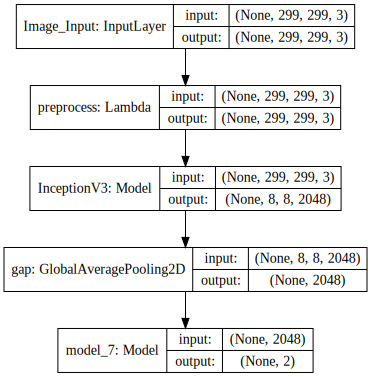

In [46]:
SVG(model_to_dot(model_clf, show_shapes=True).create(format='svg', prog='dot'))

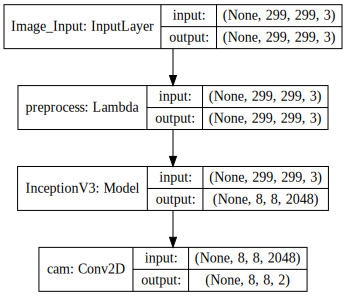

In [47]:
SVG(model_to_dot(model_cam, show_shapes=True).create(format='svg', prog='dot'))

在model_cam中，除了最后一层之外的都不会训练，即权值不会改变，我们只需要将训练好的分类器的权值load到model_cam最后一层

In [48]:
weights = model_clf.layers[-1].get_weights()[0]
print(model_iv3.get_weights()[0].shape)
print(np.array(weights).shape)
print(np.array(model_cam.layers[-1].get_weights()).shape)
cam_conv2d_weights_shape = np.array(model_cam.layers[-1].get_weights()).shape
model_cam.layers[-1].set_weights(weights.reshape(*cam_conv2d_weights_shape[:]))

(2048, 2)
(2048, 2)
(1, 1, 1, 2048, 2)


In [49]:
model_clf.save('model_clf.h5')
model_cam.save('model_cam.h5')

In [50]:
from keras.models import load_model
from keras.applications import imagenet_utils

# https://github.com/keras-team/keras/issues/8734
model_clf = load_model('model_clf.h5', custom_objects={'imagenet_utils':imagenet_utils})
model_cam = load_model('model_cam.h5', custom_objects={'imagenet_utils':imagenet_utils})

/Users/orange/anaconda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [51]:
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

5454
predict 1 99.94%


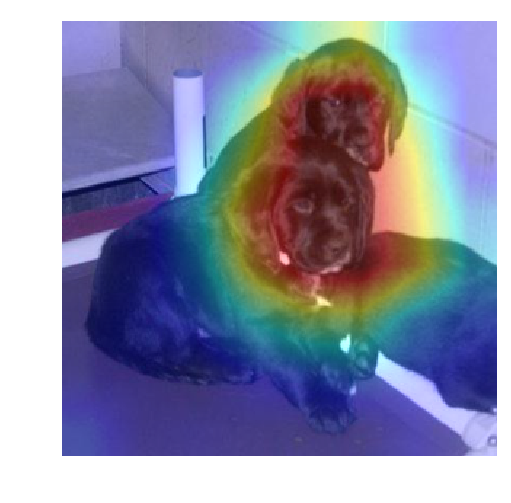

In [52]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299

idx = np.random.randint(12500)
print(idx)
#idx=10863
pX = cv2.resize(cv2.imread('data/test/test/%d.jpg' % idx), (IMAGE_WIDTH, IMAGE_HEIGHT))

# 用模型进行预测
prediction = model_clf.predict(np.expand_dims(pX, 0))
prediction = prediction[0]
clf_idx = np.argmax(prediction)
print('predict', clf_idx, '%.2f%%'%(prediction[clf_idx] * 100))

cam = model_cam.predict(np.expand_dims(pX, 0))
cam = cam[0, :, :, clf_idx]

# 调整 CAM 的范围
# CV_8UC1  8位无符号的单通道 灰度图片 
cam /= 10
cam[cam < 0] = 0
cam[cam > 1] = 1
cam = cv2.resize(cam, (299, 299))
cam = np.uint8(255*cam)

# 染成彩色
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# 加在原图上
out = cv2.addWeighted(pX, 0.8, heatmap, 0.4, 0)

# 显示图片
plt.axis('off')
plt.imshow(out[:,:,::-1])

#### 3.6 在训练集上看看模型错误预测了那些图（本应在验证集看，但没有单独保存验证集的列表）

In [29]:
import cv2
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
data_dir = './data/train/'
all_files = os.listdir(data_dir)
wrongs = []
for f in all_files:
    pX = cv2.resize(cv2.imread(os.path.join(data_dir, f)), (IMAGE_WIDTH, IMAGE_HEIGHT))
    pY = np.argmax(model_clf.predict(np.expand_dims(pX, 0)))
    y = 0 if f[:3] == 'cat' else 1
    if pY != y:
        wrongs.append(f)
print(wrongs)

['cat.10029.jpg', 'cat.10107.jpg', 'cat.10121.jpg', 'cat.10266.jpg', 'cat.10425.jpg', 'cat.10700.jpg', 'cat.10712.jpg', 'cat.10740.jpg', 'cat.10863.jpg', 'cat.11194.jpg', 'cat.11222.jpg', 'cat.11231.jpg', 'cat.11281.jpg', 'cat.11413.jpg', 'cat.11457.jpg', 'cat.11473.jpg', 'cat.11565.jpg', 'cat.11724.jpg', 'cat.11726.jpg', 'cat.12272.jpg', 'cat.12499.jpg', 'cat.1361.jpg', 'cat.1407.jpg', 'cat.1507.jpg', 'cat.1622.jpg', 'cat.1630.jpg', 'cat.2150.jpg', 'cat.2189.jpg', 'cat.2415.jpg', 'cat.2457.jpg', 'cat.3105.jpg', 'cat.3123.jpg', 'cat.3216.jpg', 'cat.3300.jpg', 'cat.3566.jpg', 'cat.3641.jpg', 'cat.3753.jpg', 'cat.3822.jpg', 'cat.3845.jpg', 'cat.3868.jpg', 'cat.4031.jpg', 'cat.4085.jpg', 'cat.4308.jpg', 'cat.4390.jpg', 'cat.4688.jpg', 'cat.4852.jpg', 'cat.4952.jpg', 'cat.4986.jpg', 'cat.4994.jpg', 'cat.5241.jpg', 'cat.5347.jpg', 'cat.5351.jpg', 'cat.5355.jpg', 'cat.5418.jpg', 'cat.5461.jpg', 'cat.5583.jpg', 'cat.5733.jpg', 'cat.5820.jpg', 'cat.6429.jpg', 'cat.6655.jpg', 'cat.6699.jpg', 'c

In [56]:
print(len(wrongs))

181


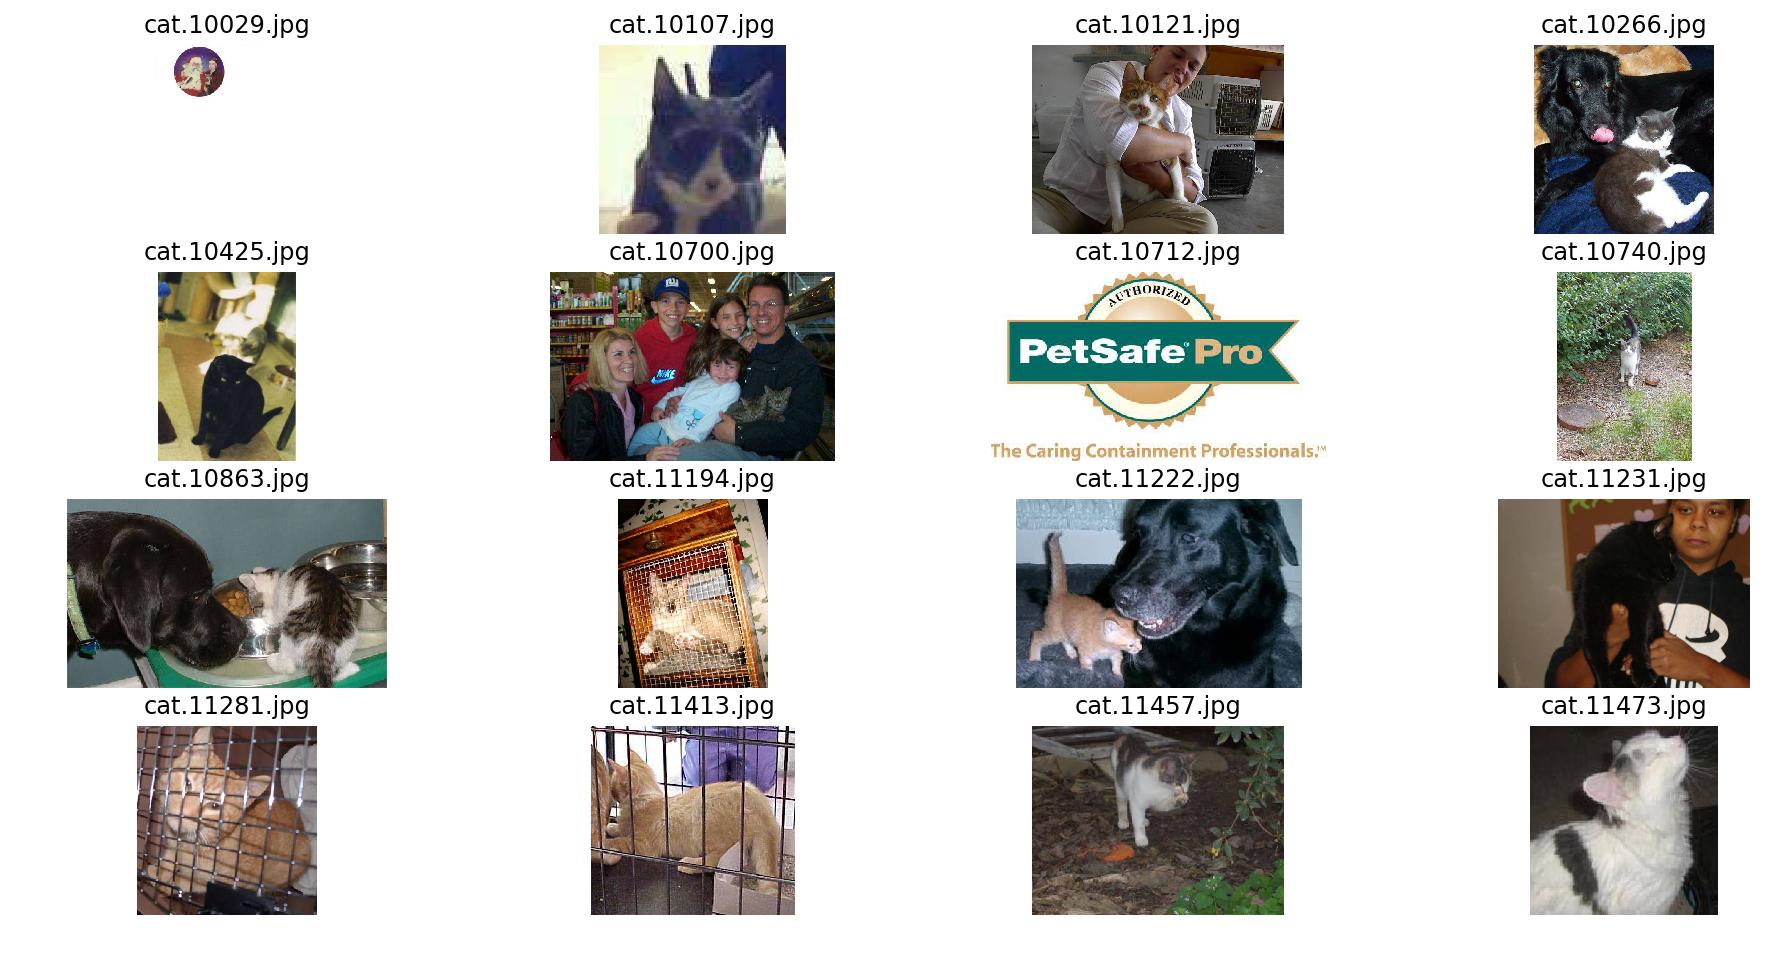

In [39]:
NUM_SHOW = 16
to_show = wrongs[:NUM_SHOW]
show_images([np.array(PIL.Image.open(os.path.join(data_dir, f)).convert('RGB')) for f in to_show], NUM_SHOW/4, to_show)

### 额外的测试图片

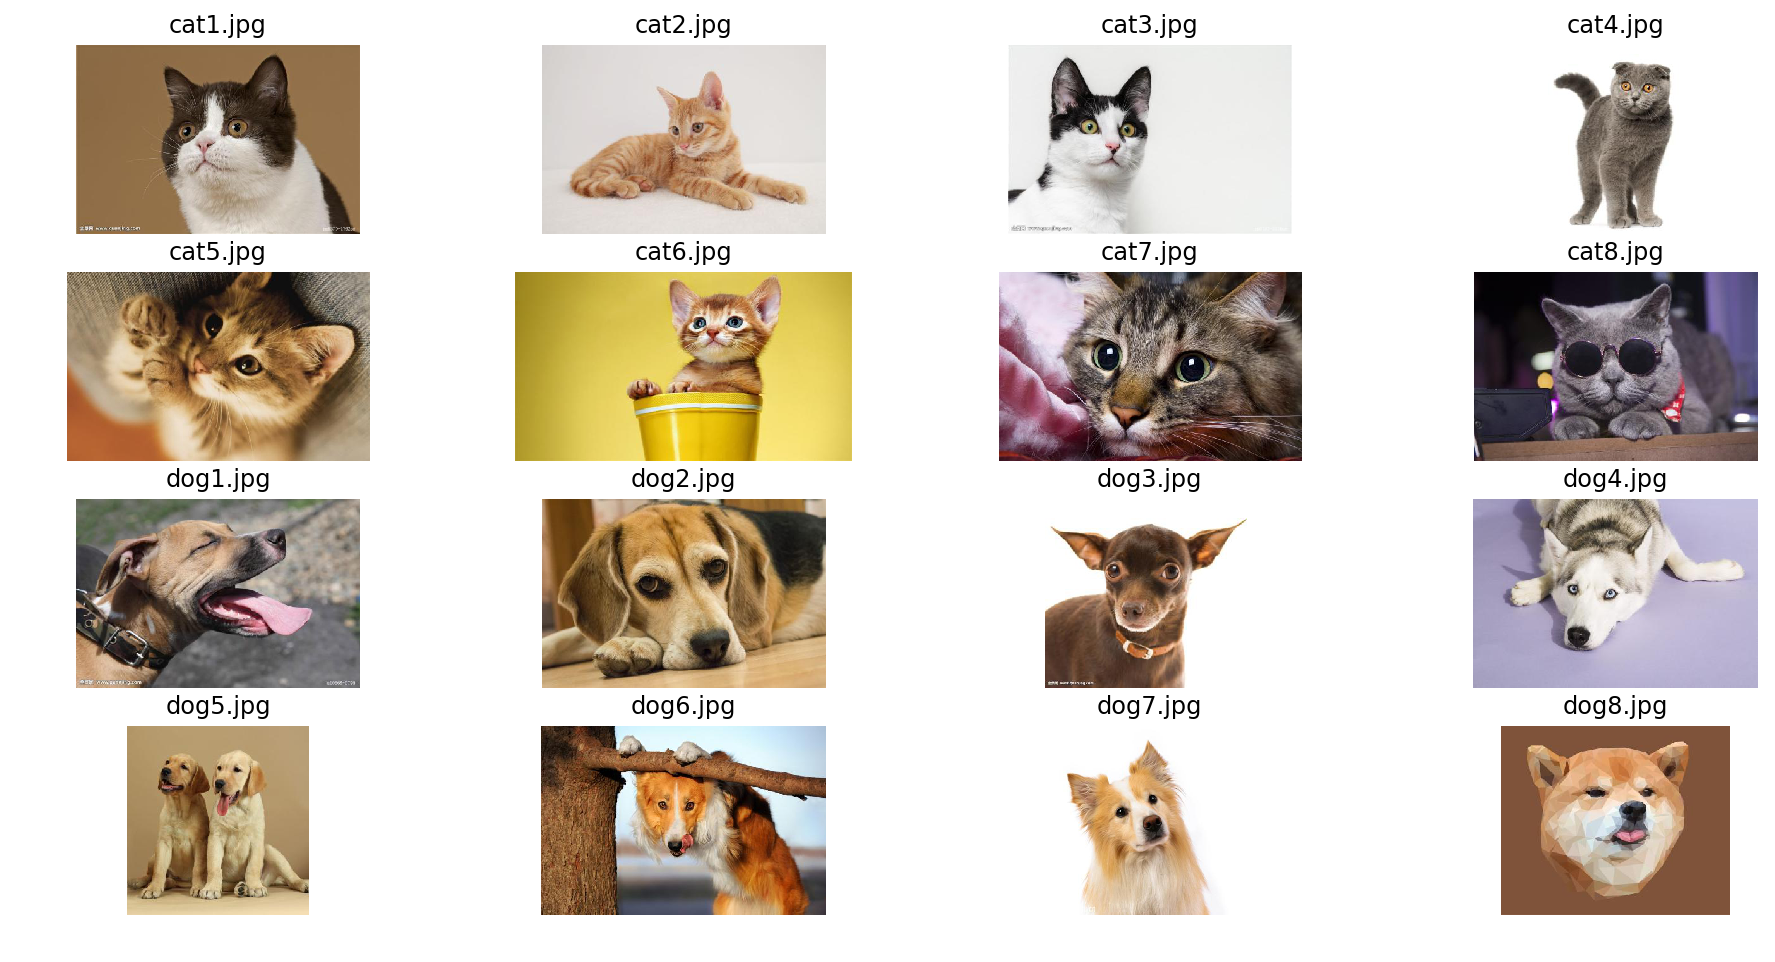

In [59]:
NUM_SHOW = 16
extra_dir = './extra/'
all_files = os.listdir(extra_dir)
show_images([np.array(PIL.Image.open(os.path.join(extra_dir, f)).convert('RGB')) for f in all_files], NUM_SHOW/4, all_files)

predict cat1.jpg as cat 100.00%
predict cat2.jpg as cat 100.00%
predict cat3.jpg as cat 100.00%
predict cat4.jpg as cat 100.00%
predict cat5.jpg as cat 100.00%
predict cat6.jpg as cat 100.00%
predict cat7.jpg as cat 100.00%
predict cat8.jpg as cat 100.00%
predict dog1.jpg as dog 100.00%
predict dog2.jpg as dog 99.70%
predict dog3.jpg as dog 99.63%
predict dog4.jpg as dog 97.93%
predict dog5.jpg as dog 99.46%
predict dog6.jpg as dog 99.32%
predict dog7.jpg as dog 99.63%
predict dog8.jpg as dog 82.20%


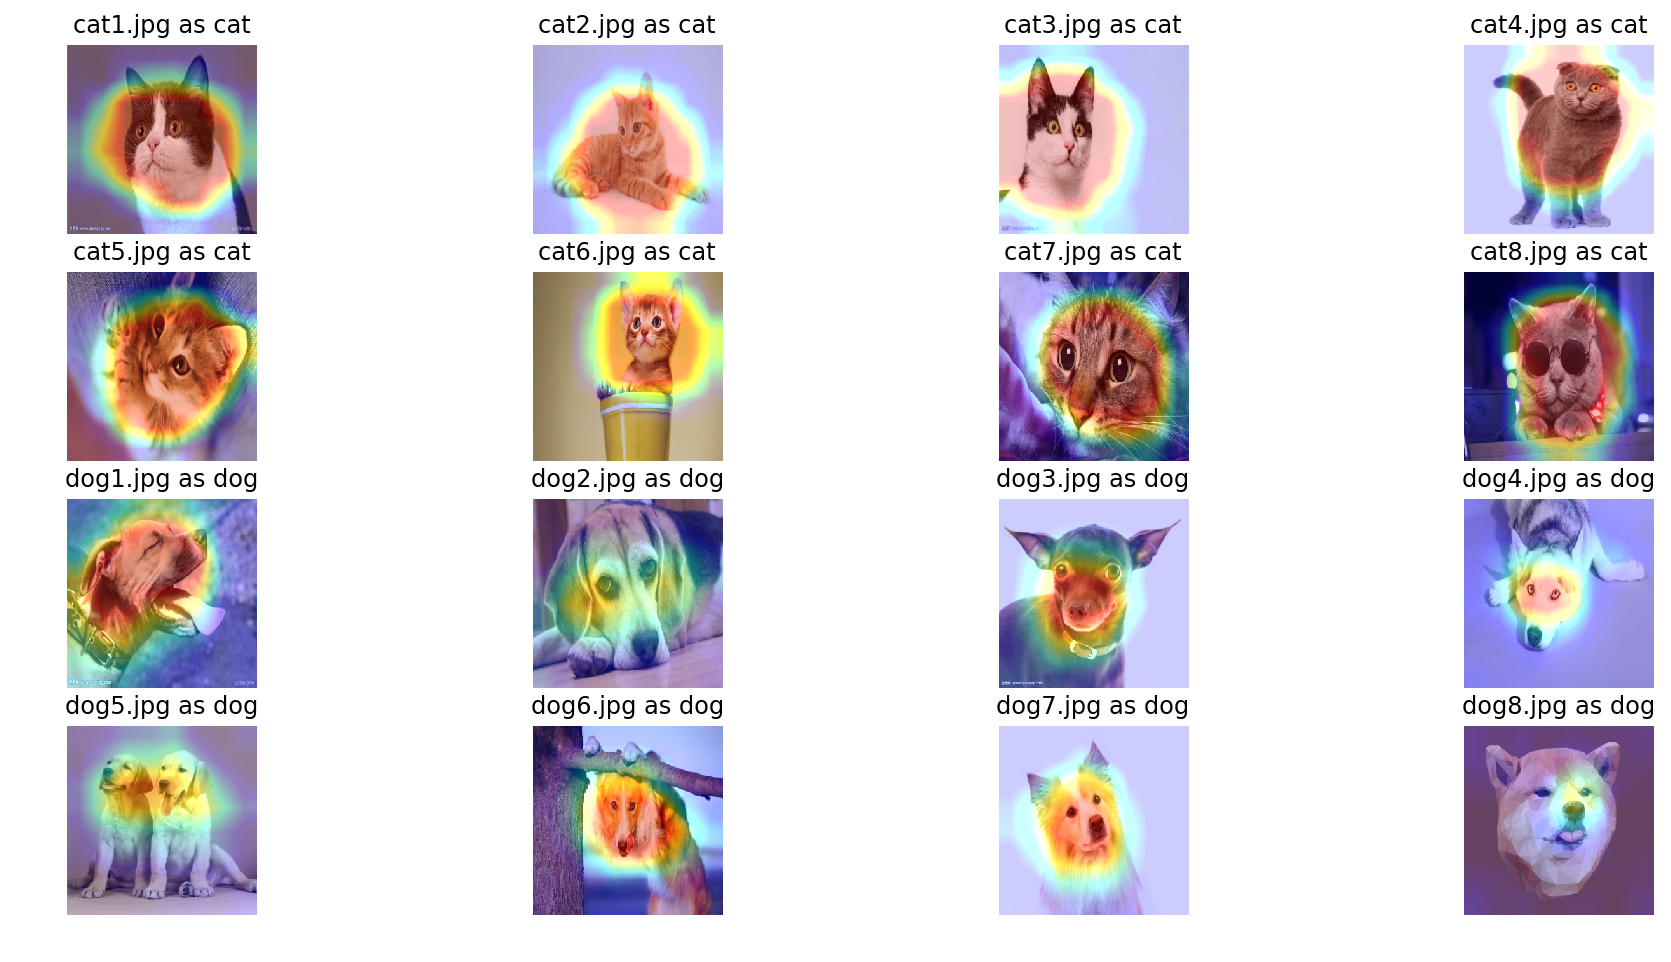

In [79]:
extra_cams = [None] * len(all_files)
predicts = [None] * len(all_files)
for idx, f in enumerate(all_files):
    pX = cv2.resize(cv2.imread(os.path.join(extra_dir, f)), (IMAGE_WIDTH, IMAGE_HEIGHT))
    # 用模型进行预测
    prediction = model_clf.predict(np.expand_dims(pX, 0))
    prediction = prediction[0]
    clf_idx = np.argmax(prediction)
    predict_str = 'cat' if clf_idx == 0 else 'dog'
    print('predict', f, 'as', predict_str, '%.2f%%'%(prediction[clf_idx] * 100))
    
    cam = model_cam.predict(np.expand_dims(pX, 0))
    cam = cam[0, :, :, clf_idx]

    # 调整 CAM 的范围
    # CV_8UC1  8位无符号的单通道 灰度图片 
    cam /= 10
    cam[cam < 0] = 0
    cam[cam > 1] = 1
    cam = cv2.resize(cam, (299, 299))
    cam = np.uint8(255*cam)

    # 染成彩色
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    out = cv2.addWeighted(pX, 0.8, heatmap, 0.4, 0)
    extra_cams[idx] = out
    predicts[idx] = predict_str

    
fig = plt.figure(figsize=(16, 8))
for n, (image, title) in enumerate(zip(extra_cams, ['%s as %s'%(all_files[i], predicts[i]) for i in range(len(extra_cams))])):
    a = fig.add_subplot(4, np.ceil(len(extra_cams)/4), n + 1)
    plt.imshow(image[:, :, ::-1], interpolation='nearest')
    a.set_title(title)
    a.axis('off')
plt.show()